<a href="https://www.kaggle.com/code/gargivipat/poem-generator?scriptVersionId=164843097" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/poems/poems-100.csv


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical

2024-02-29 11:09:56.741867: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 11:09:56.742010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 11:09:56.880440: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading Data

In [3]:
df = pd.read_csv("/kaggle/input/poems/poems-100.csv")

In [4]:
df.head()

,text
0,"O my Luve's like a red, red rose\nThat’s newly..."
1,"The rose is red,\nThe violet's blue,\nSugar is..."
2,How do I love thee? Let me count the ways.\nI ...
3,"Had I the heavens' embroidered cloths,\nEnwrou..."
4,"I.\n Enough! we're tired, my heart and I.\n..."


In [5]:
df.shape

(100, 1)

# Visualizing

In [6]:
df['text'][0]

"O my Luve's like a red, red rose\nThat’s newly sprung in June;\nO my Luve's like the melodie\nThat’s sweetly play'd in tune.\n\nAs fair art thou, my bonnie lass,\nSo deep in luve am I:\nAnd I will luve thee still, my dear,\nTill a’ the seas gang dry:\n\nTill a’ the seas gang dry, my dear,\nAnd the rocks melt wi’ the sun:\nI will luve thee still, my dear,\nWhile the sands o’ life shall run.\n\nAnd fare thee well, my only Luve\nAnd fare thee well, a while!\nAnd I will come again, my Luve,\nTho’ it were ten thousand mile."

In [7]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [8]:
words = ''
stopwords = set(STOPWORDS)

In [9]:
# df.text

In [10]:
for val in df.text:
    val = str(val)
    tokens = val.split()
    
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    words+=" ".join(tokens)+" "
wordcloud = WordCloud(width=800,height=800,
                     background_color = 'black',
                     stopwords=stopwords,
                     min_font_size=10).generate(words)    

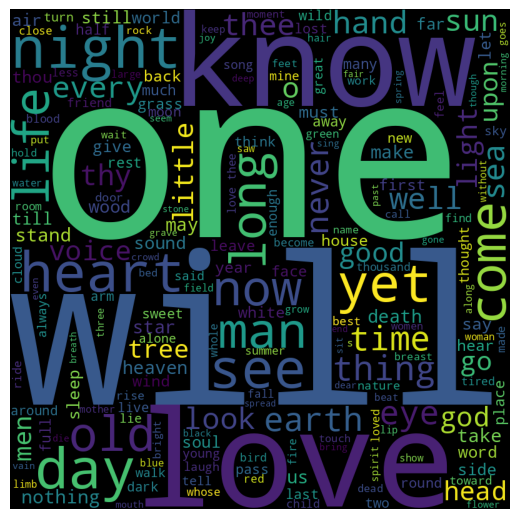

In [11]:
plt.figure(figsize=(5,5),facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

# Preprocessing

In [12]:
len(df['text'][0])

506

In [13]:
text = df['text'].values

In [14]:
len(text)

100

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
tokens = tokenizer.texts_to_sequences(text)

In [16]:
# tokenizer.get_config()

In [17]:
X = []
y = []
for t in tokens:
    for i in range(1,len(t)):
        X.append(t[:i])
        y.append(t[i])

In [18]:
# print(y[0:10])

In [19]:
# help(tokenizer)

In [20]:
# len(tokenizer.index_word)

In [21]:
vocab_size = len(tokenizer.index_word)+1

In [22]:
X = pad_sequences(X,padding="pre")
y = to_categorical(y,num_classes=vocab_size)

In [23]:
y[100]

array([0., 0., 0., ..., 0., 0., 0.])

***For understanding what index_word is:***

In [24]:
# ind = 0
# for i,num in enumerate(y[100]):
#     if num==1:
#         ind = i

In [25]:
# ind

In [26]:
# tokenizer.index_word[13]

In [27]:
len(X[100])

2026

In [28]:
X

array([[   0,    0,    0, ...,    0,    0,  105],
       [   0,    0,    0, ...,    0,  105,    8],
       [   0,    0,    0, ...,  105,    8, 1175],
       ...,
       [   0,    0,    0, ...,   26,    1,  233],
       [   0,    0,    0, ...,    1,  233,    3],
       [   0,    0,    0, ...,  233,    3, 5396]], dtype=int32)

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,GRU

In [30]:
embed_dim = 300
neurons = 256

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import *
from keras.losses import * 

In [32]:
from tensorflow.keras import backend as back
in_shape = Input(shape=(None,))
a = Embedding(vocab_size,embed_dim)(in_shape)
b = GRU(neurons,return_sequences=True)(a)
b = GRU(neurons,return_sequences=True)(b)
c = Dense(1,activation='tanh')(b)
r = Reshape([-1])(c)
alpha = Activation('softmax')(r)
e = Permute([2,1])(RepeatVector(neurons)(alpha))
e = Multiply()([b,e])
e = Lambda(lambda xin : back.sum(xin,axis=1),output_shape=(neurons,))(e)
out = Dense(vocab_size,activation='softmax',name='output')(e)
# out = Reshape((-1,vocab_size))(out)

# target = Input(shape=(None,))
# out = Lambda(lambda x: back.expand_dims(x,axis=-1))(target)

In [33]:
model = tf.keras.models.Model(inputs=[in_shape],outputs=[out])
model.compile(optimizer='adam',loss=CategoricalCrossentropy(),metrics=['accuracy'])

In [34]:
# model = create_model(vocab_size,embed_dim,neurons)

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

In [36]:
early_stop = EarlyStopping(monitor='accuracy',patience=2)

In [37]:
model.fit(X,y,epochs=20,validation_split=0.2,batch_size=100,callbacks=[early_stop])

Epoch 1/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 109s 524ms/step - accuracy: 0.0696 - loss: 7.2634 - val_accuracy: 0.0561 - val_loss: 7.2259
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 109s 544ms/step - accuracy: 0.0739 - loss: 6.6401 - val_accuracy: 0.0561 - val_loss: 7.4298
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 109s 542ms/step - accuracy: 0.0747 - loss: 6.6315 - val_accuracy: 0.0561 - val_loss: 7.4542
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 109s 541ms/step - accuracy: 0.0736 - loss: 6.5800 - val_accuracy: 0.0561 - val_loss: 7.4929
Epoch 5/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 143s 543ms/step - accuracy: 0.0752 - loss: 6.5268 - val_accuracy: 0.0561 - val_loss: 7.5688


In [38]:
model.save('poem_generator_1.h5')

In [39]:
model_summary = model.history.history

In [40]:
summary = pd.DataFrame(model_summary)

In [41]:
accuracies = summary.drop(['loss','val_loss'],axis=1)

<Axes: >

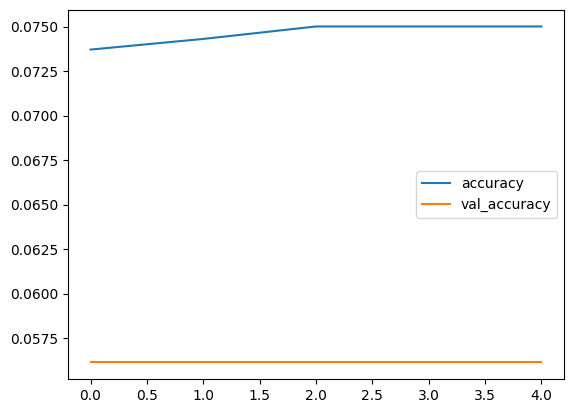

In [42]:
accuracies.plot()

In [43]:
losses = summary.drop(['accuracy','val_accuracy'],axis=1)

<Axes: >

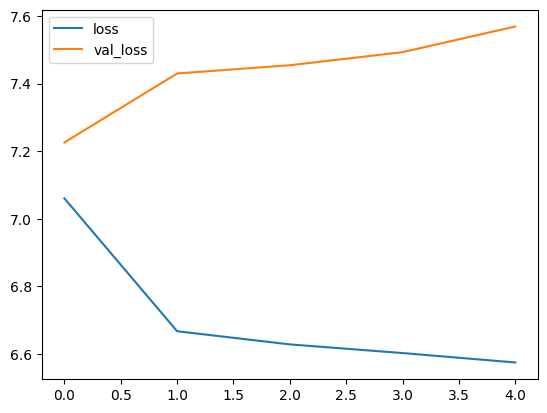

In [44]:
losses.plot()

Final metrics of this model: 
* Accuracy: 0.0735 
* Loss: 6.5838
* Val_accuracy: 0.0561
* Val_loss: 7.5211

In [45]:
def create_model(vocab_size,embed_dim,neurons):
    model = Sequential()
    model.add(Embedding(vocab_size,embed_dim))
    model.add(LSTM(neurons))
    
    model.add(Dropout(0.2))
    
    model.add(Dense(vocab_size,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

In [46]:
model = create_model(vocab_size,embed_dim,100)

In [47]:
model.fit(X,y,validation_split=0.2,epochs=20)

Epoch 1/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 56s 86ms/step - accuracy: 0.0664 - loss: 7.1704 - val_accuracy: 0.0623 - val_loss: 7.0505
Epoch 2/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.0917 - loss: 6.3819 - val_accuracy: 0.0779 - val_loss: 7.1234
Epoch 3/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.1124 - loss: 6.0537 - val_accuracy: 0.0841 - val_loss: 7.2106
Epoch 4/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.1302 - loss: 5.7694 - val_accuracy: 0.0791 - val_loss: 7.3873
Epoch 5/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.1425 - loss: 5.4989 - val_accuracy: 0.0803 - val_loss: 7.5675
Epoch 6/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.1652 - loss: 5.1788 - val_accuracy: 0.0763 - val_loss: 7.7457
Epoch 7/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.1777 - loss: 4.8991 - val_accuracy: 0.0667 - val_loss: 7.9567
Epoch 8/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.2004 - loss: 4.5834 - 

In [48]:
model_sum_1 = model.history.history

In [49]:
summary_1 = pd.DataFrame(model_sum_1)

In [50]:
accuracies_1 = summary_1.drop(['loss','val_loss'],axis=1)
losses_1 = summary_1.drop(['accuracy','val_accuracy'],axis=1)

<Axes: >

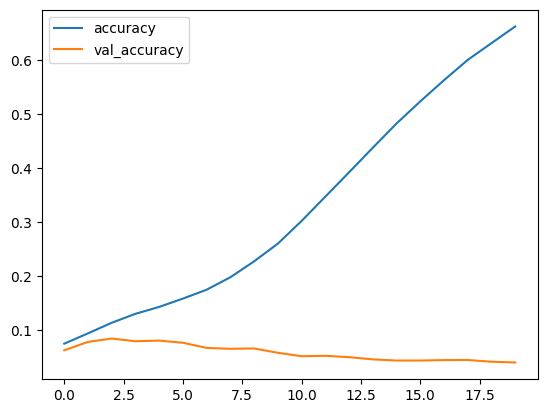

In [51]:
accuracies_1.plot()

<Axes: >

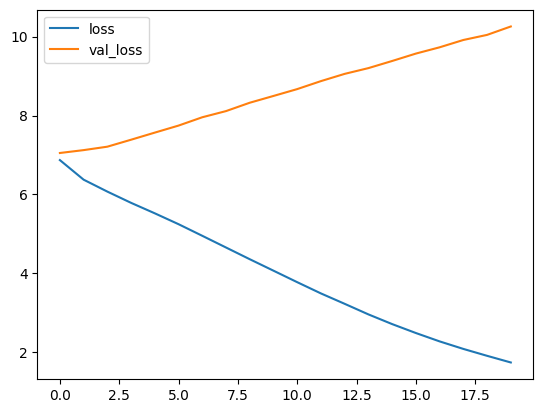

In [52]:
losses_1.plot()

*The problem of validation loss moving up and training loss going down still persists*